In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [8]:
runs = [304125,302263,304508]
cnorm = 5
with open("good_data_CNorm"+str(cnorm)+".pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1


1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


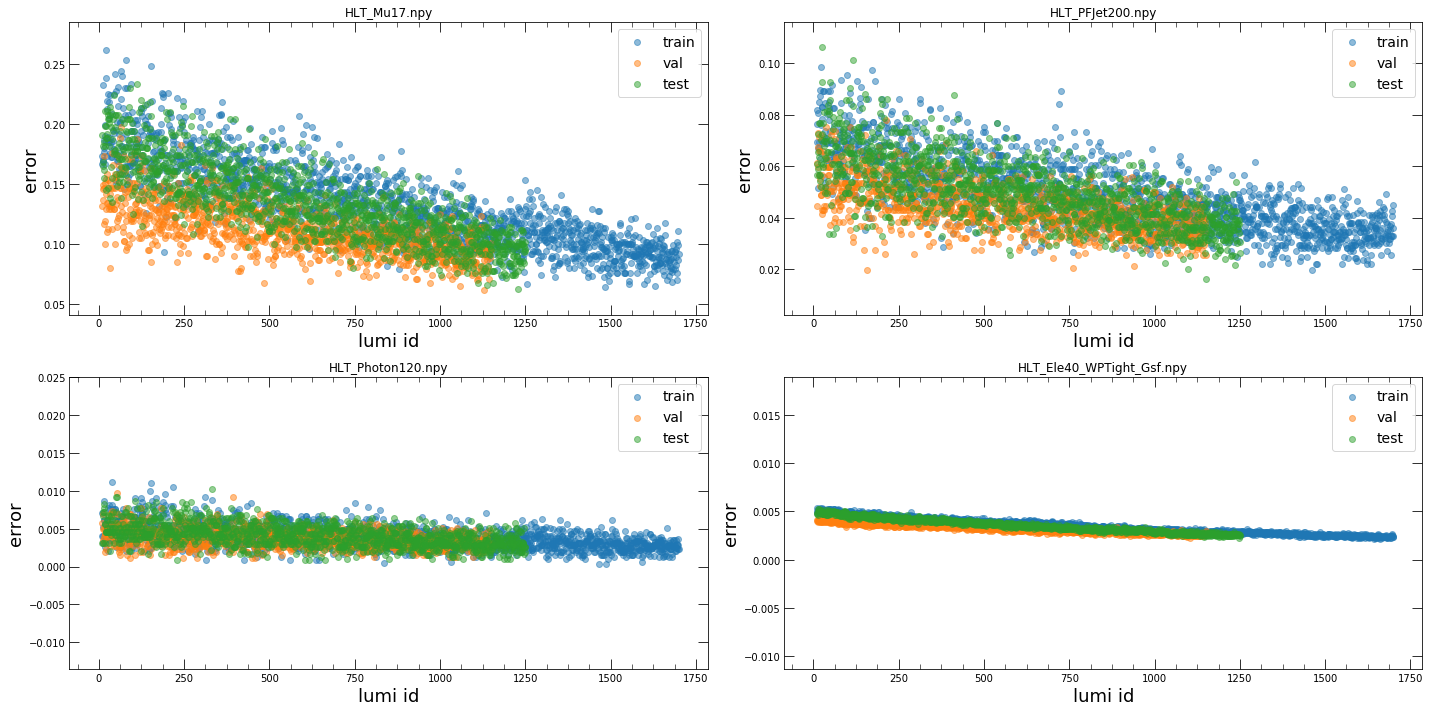

In [9]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [10]:
model_name = "simplest_" + str(cnorm)

In [11]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
reconstructed (Dense)        (None, 4)                 16        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1129 samples
Epoch 1/1000
 - 0s - loss: 0.2888 - val_loss: 0.2039
Epoch 2/1000
 - 0s - loss: 0.2819 - val_loss: 0.1988
Epoch 3/1000
 - 0s - loss: 0.2749 - val_loss: 0.1936
Epoch 4/1000
 - 0s - loss: 0.2678 - val_loss: 0.1886
Epoch 5/1000
 - 0s - loss: 0.2608 - val_loss: 0.1836
Epoch 6/1000
 - 0s - loss: 0.2539 - val_loss: 0.1788
Epoch 7/1000
 - 0s - loss: 0.2473 - val_loss: 0.1741
Epoch 8/1000
 - 0s - loss: 0.2408 - val_loss: 0.1695
Epoch 9/1000
 - 0s - loss: 0.2344 - val_loss: 0.1650
Epoch 10/1000
 - 0s - loss: 0.2282 - val_loss: 0.1607
Epoch 11/1000
 - 0s - loss: 0.2222 - val_loss: 0.1564
Epoch 12/1000
 - 0s - loss: 0.2163 - val_loss: 0.1522
Epoch 13/1000
 - 0s - loss: 0.2106 - val_loss: 0.1482
Epoch 14/1000
 - 0s - loss: 0.2049 - val_loss: 0.1443
Epoch 15/1000
 - 0s - loss: 0.1995 - val_loss: 0.1404
Epoch 16/1000
 - 0s - loss: 0.1942 - val_loss: 0.1367
Epoch 17/1000
 - 0s - loss: 0.1891 - val_loss: 0.1331
Epoch 18/1000
 - 0s - loss: 0.1841 - val_lo

 - 0s - loss: 0.0122 - val_loss: 0.0086
Epoch 152/1000
 - 0s - loss: 0.0120 - val_loss: 0.0085
Epoch 153/1000
 - 0s - loss: 0.0119 - val_loss: 0.0084
Epoch 154/1000
 - 0s - loss: 0.0117 - val_loss: 0.0082
Epoch 155/1000
 - 0s - loss: 0.0115 - val_loss: 0.0081
Epoch 156/1000
 - 0s - loss: 0.0113 - val_loss: 0.0080
Epoch 157/1000
 - 0s - loss: 0.0112 - val_loss: 0.0079
Epoch 158/1000
 - 0s - loss: 0.0110 - val_loss: 0.0078
Epoch 159/1000
 - 0s - loss: 0.0108 - val_loss: 0.0076
Epoch 160/1000
 - 0s - loss: 0.0107 - val_loss: 0.0075
Epoch 161/1000
 - 0s - loss: 0.0105 - val_loss: 0.0074
Epoch 162/1000
 - 0s - loss: 0.0104 - val_loss: 0.0073
Epoch 163/1000
 - 0s - loss: 0.0102 - val_loss: 0.0072
Epoch 164/1000
 - 0s - loss: 0.0101 - val_loss: 0.0071
Epoch 165/1000
 - 0s - loss: 0.0099 - val_loss: 0.0070
Epoch 166/1000
 - 0s - loss: 0.0098 - val_loss: 0.0069
Epoch 167/1000
 - 0s - loss: 0.0097 - val_loss: 0.0068
Epoch 168/1000
 - 0s - loss: 0.0095 - val_loss: 0.0067
Epoch 169/1000
 - 0s - lo

Epoch 301/1000
 - 0s - loss: 0.0021 - val_loss: 0.0015
Epoch 302/1000
 - 0s - loss: 0.0021 - val_loss: 0.0015
Epoch 303/1000
 - 0s - loss: 0.0021 - val_loss: 0.0015
Epoch 304/1000
 - 0s - loss: 0.0021 - val_loss: 0.0014
Epoch 305/1000
 - 0s - loss: 0.0021 - val_loss: 0.0014
Epoch 306/1000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 307/1000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 308/1000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 309/1000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 310/1000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 311/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 312/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 313/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 314/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 315/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 316/1000
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 317/1000
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 318/1000
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 319/

Epoch 440/1000
 - 0s - loss: 6.7113e-04 - val_loss: 4.6149e-04
Epoch 441/1000
 - 0s - loss: 6.6621e-04 - val_loss: 4.5808e-04
Epoch 442/1000
 - 0s - loss: 6.6130e-04 - val_loss: 4.5469e-04
Epoch 443/1000
 - 0s - loss: 6.5648e-04 - val_loss: 4.5134e-04
Epoch 444/1000
 - 0s - loss: 6.5168e-04 - val_loss: 4.4802e-04
Epoch 445/1000
 - 0s - loss: 6.4690e-04 - val_loss: 4.4472e-04
Epoch 446/1000
 - 0s - loss: 6.4219e-04 - val_loss: 4.4146e-04
Epoch 447/1000
 - 0s - loss: 6.3751e-04 - val_loss: 4.3823e-04
Epoch 448/1000
 - 0s - loss: 6.3288e-04 - val_loss: 4.3502e-04
Epoch 449/1000
 - 0s - loss: 6.2830e-04 - val_loss: 4.3185e-04
Epoch 450/1000
 - 0s - loss: 6.2370e-04 - val_loss: 4.2870e-04
Epoch 451/1000
 - 0s - loss: 6.1921e-04 - val_loss: 4.2558e-04
Epoch 452/1000
 - 0s - loss: 6.1475e-04 - val_loss: 4.2250e-04
Epoch 453/1000
 - 0s - loss: 6.1031e-04 - val_loss: 4.1944e-04
Epoch 454/1000
 - 0s - loss: 6.0590e-04 - val_loss: 4.1640e-04
Epoch 455/1000
 - 0s - loss: 6.0155e-04 - val_loss: 4.1

Epoch 571/1000
 - 0s - loss: 2.7988e-04 - val_loss: 1.9240e-04
Epoch 572/1000
 - 0s - loss: 2.7821e-04 - val_loss: 1.9125e-04
Epoch 573/1000
 - 0s - loss: 2.7655e-04 - val_loss: 1.9011e-04
Epoch 574/1000
 - 0s - loss: 2.7490e-04 - val_loss: 1.8898e-04
Epoch 575/1000
 - 0s - loss: 2.7326e-04 - val_loss: 1.8786e-04
Epoch 576/1000
 - 0s - loss: 2.7164e-04 - val_loss: 1.8676e-04
Epoch 577/1000
 - 0s - loss: 2.7003e-04 - val_loss: 1.8566e-04
Epoch 578/1000
 - 0s - loss: 2.6842e-04 - val_loss: 1.8457e-04
Epoch 579/1000
 - 0s - loss: 2.6683e-04 - val_loss: 1.8349e-04
Epoch 580/1000
 - 0s - loss: 2.6525e-04 - val_loss: 1.8242e-04
Epoch 581/1000
 - 0s - loss: 2.6369e-04 - val_loss: 1.8138e-04
Epoch 582/1000
 - 0s - loss: 2.6213e-04 - val_loss: 1.8034e-04
Epoch 583/1000
 - 0s - loss: 2.6058e-04 - val_loss: 1.7930e-04
Epoch 584/1000
 - 0s - loss: 2.5906e-04 - val_loss: 1.7827e-04
Epoch 585/1000
 - 0s - loss: 2.5753e-04 - val_loss: 1.7726e-04
Epoch 586/1000
 - 0s - loss: 2.5602e-04 - val_loss: 1.7

 - 0s - loss: 1.3943e-04 - val_loss: 9.6928e-05
Epoch 702/1000
 - 0s - loss: 1.3879e-04 - val_loss: 9.6490e-05
Epoch 703/1000
 - 0s - loss: 1.3814e-04 - val_loss: 9.6047e-05
Epoch 704/1000
 - 0s - loss: 1.3750e-04 - val_loss: 9.5613e-05
Epoch 705/1000
 - 0s - loss: 1.3686e-04 - val_loss: 9.5186e-05
Epoch 706/1000
 - 0s - loss: 1.3623e-04 - val_loss: 9.4761e-05
Epoch 707/1000
 - 0s - loss: 1.3560e-04 - val_loss: 9.4346e-05
Epoch 708/1000
 - 0s - loss: 1.3498e-04 - val_loss: 9.3933e-05
Epoch 709/1000
 - 0s - loss: 1.3436e-04 - val_loss: 9.3525e-05
Epoch 710/1000
 - 0s - loss: 1.3375e-04 - val_loss: 9.3117e-05
Epoch 711/1000
 - 0s - loss: 1.3314e-04 - val_loss: 9.2720e-05
Epoch 712/1000
 - 0s - loss: 1.3254e-04 - val_loss: 9.2328e-05
Epoch 713/1000
 - 0s - loss: 1.3193e-04 - val_loss: 9.1918e-05
Epoch 714/1000
 - 0s - loss: 1.3134e-04 - val_loss: 9.1520e-05
Epoch 715/1000
 - 0s - loss: 1.3074e-04 - val_loss: 9.1115e-05
Epoch 716/1000
 - 0s - loss: 1.3015e-04 - val_loss: 9.0720e-05
Epoch 7

Epoch 832/1000
 - 0s - loss: 8.3631e-05 - val_loss: 5.9413e-05
Epoch 833/1000
 - 0s - loss: 8.3373e-05 - val_loss: 5.9243e-05
Epoch 834/1000
 - 0s - loss: 8.3115e-05 - val_loss: 5.9072e-05
Epoch 835/1000
 - 0s - loss: 8.2860e-05 - val_loss: 5.8901e-05
Epoch 836/1000
 - 0s - loss: 8.2608e-05 - val_loss: 5.8735e-05
Epoch 837/1000
 - 0s - loss: 8.2356e-05 - val_loss: 5.8571e-05
Epoch 838/1000
 - 0s - loss: 8.2108e-05 - val_loss: 5.8409e-05
Epoch 839/1000
 - 0s - loss: 8.1859e-05 - val_loss: 5.8241e-05
Epoch 840/1000
 - 0s - loss: 8.1613e-05 - val_loss: 5.8075e-05
Epoch 841/1000
 - 0s - loss: 8.1369e-05 - val_loss: 5.7907e-05
Epoch 842/1000
 - 0s - loss: 8.1126e-05 - val_loss: 5.7734e-05
Epoch 843/1000
 - 0s - loss: 8.0886e-05 - val_loss: 5.7575e-05
Epoch 844/1000
 - 0s - loss: 8.0647e-05 - val_loss: 5.7415e-05
Epoch 845/1000
 - 0s - loss: 8.0411e-05 - val_loss: 5.7253e-05
Epoch 846/1000
 - 0s - loss: 8.0176e-05 - val_loss: 5.7093e-05
Epoch 847/1000
 - 0s - loss: 7.9939e-05 - val_loss: 5.6

Epoch 963/1000
 - 0s - loss: 6.1498e-05 - val_loss: 4.4499e-05
Epoch 964/1000
 - 0s - loss: 6.1398e-05 - val_loss: 4.4432e-05
Epoch 965/1000
 - 0s - loss: 6.1295e-05 - val_loss: 4.4352e-05
Epoch 966/1000
 - 0s - loss: 6.1194e-05 - val_loss: 4.4277e-05
Epoch 967/1000
 - 0s - loss: 6.1093e-05 - val_loss: 4.4198e-05
Epoch 968/1000
 - 0s - loss: 6.0994e-05 - val_loss: 4.4129e-05
Epoch 969/1000
 - 0s - loss: 6.0895e-05 - val_loss: 4.4060e-05
Epoch 970/1000
 - 0s - loss: 6.0797e-05 - val_loss: 4.3993e-05
Epoch 971/1000
 - 0s - loss: 6.0698e-05 - val_loss: 4.3929e-05
Epoch 972/1000
 - 0s - loss: 6.0602e-05 - val_loss: 4.3864e-05
Epoch 973/1000
 - 0s - loss: 6.0505e-05 - val_loss: 4.3808e-05
Epoch 974/1000
 - 0s - loss: 6.0409e-05 - val_loss: 4.3753e-05
Epoch 975/1000
 - 0s - loss: 6.0314e-05 - val_loss: 4.3705e-05
Epoch 976/1000
 - 0s - loss: 6.0220e-05 - val_loss: 4.3656e-05
Epoch 977/1000
 - 0s - loss: 6.0126e-05 - val_loss: 4.3602e-05
Epoch 978/1000
 - 0s - loss: 6.0033e-05 - val_loss: 4.3

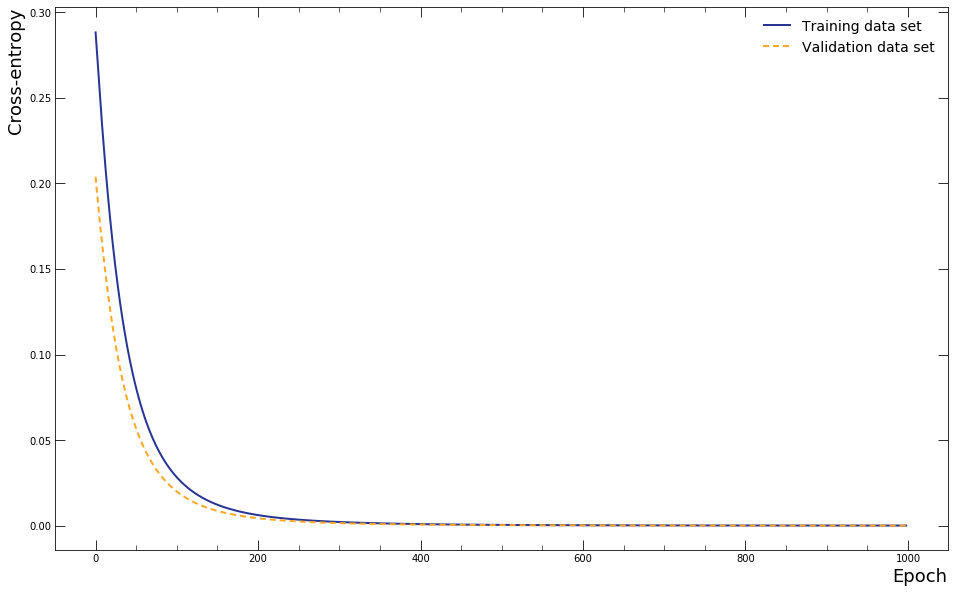

In [12]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

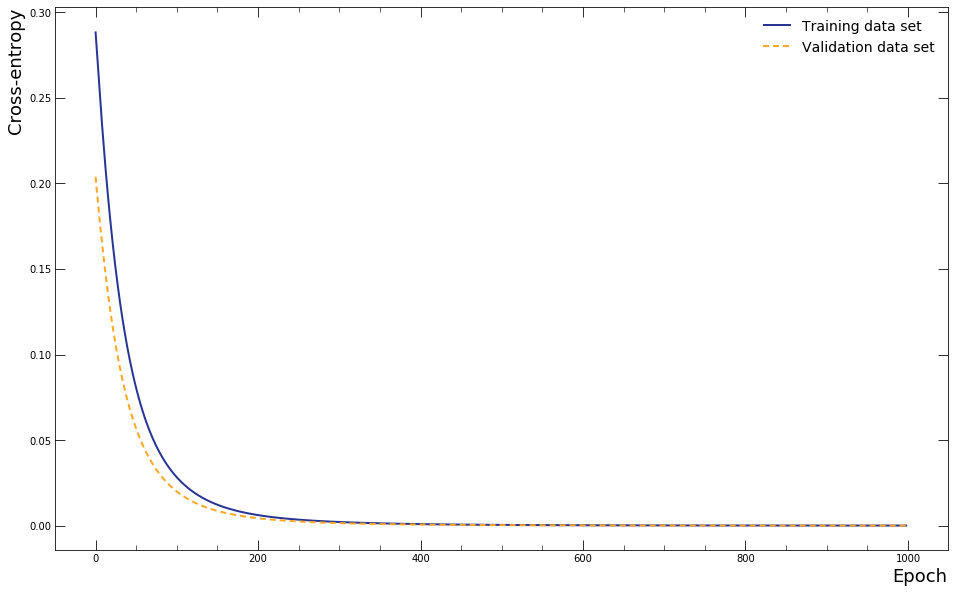

In [13]:
plot_loss(history)

## Training Set

In [14]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = abs(x_train_new-reconstructed)/x_train_new

In [15]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

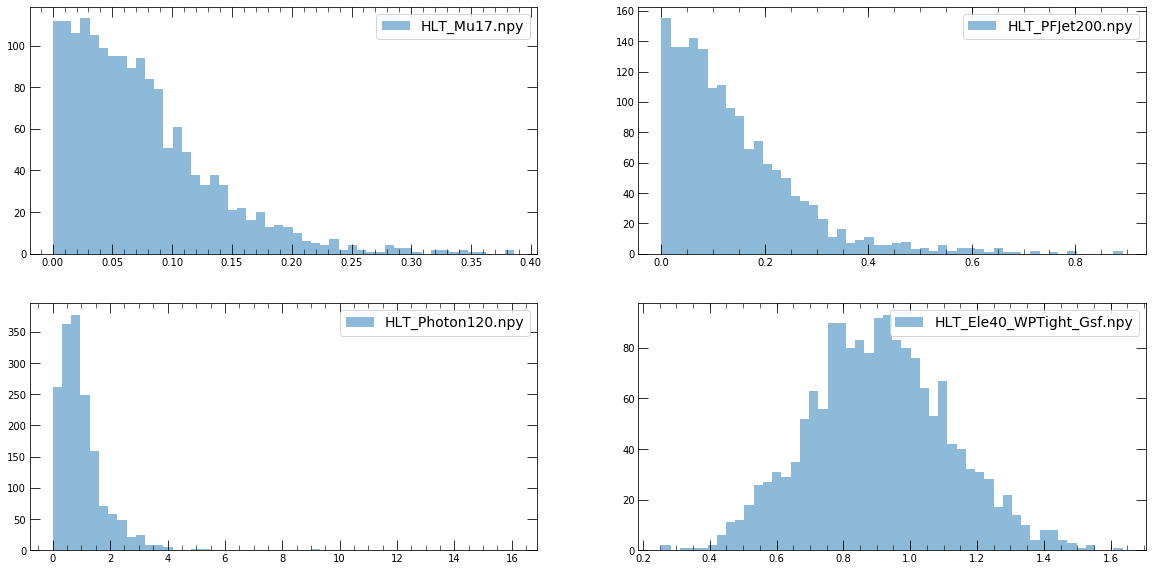

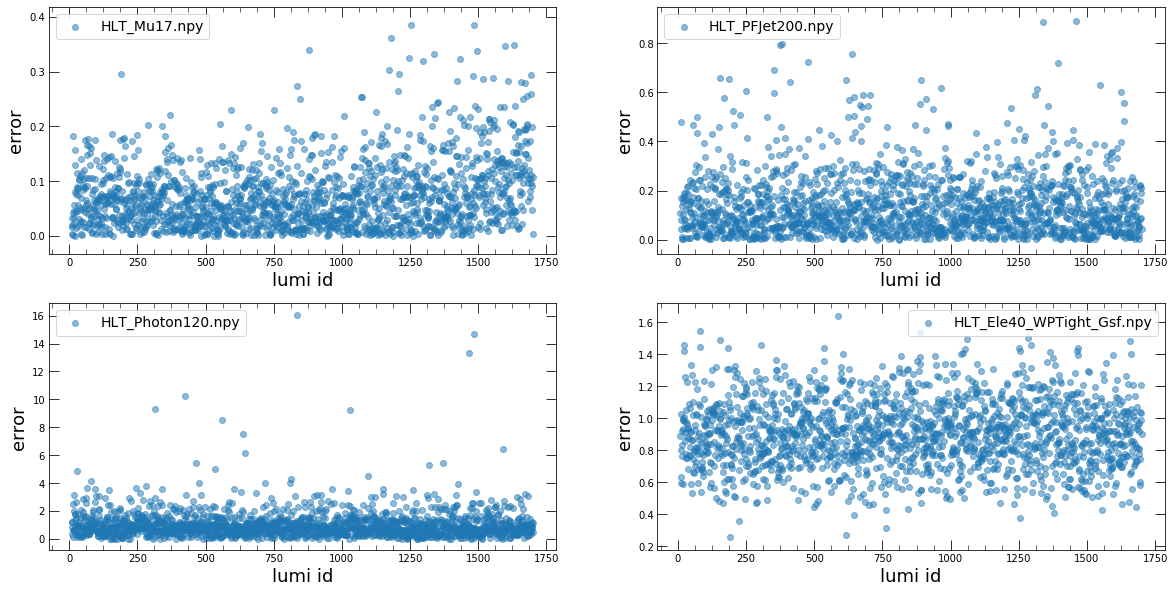

In [16]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

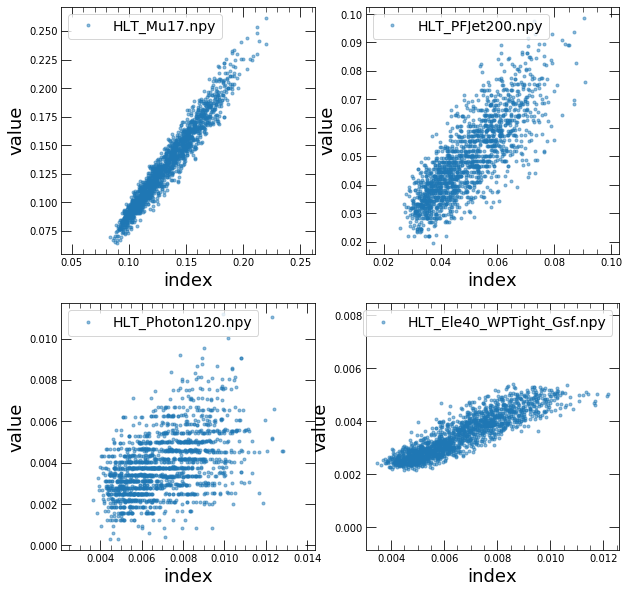

In [17]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [18]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [19]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

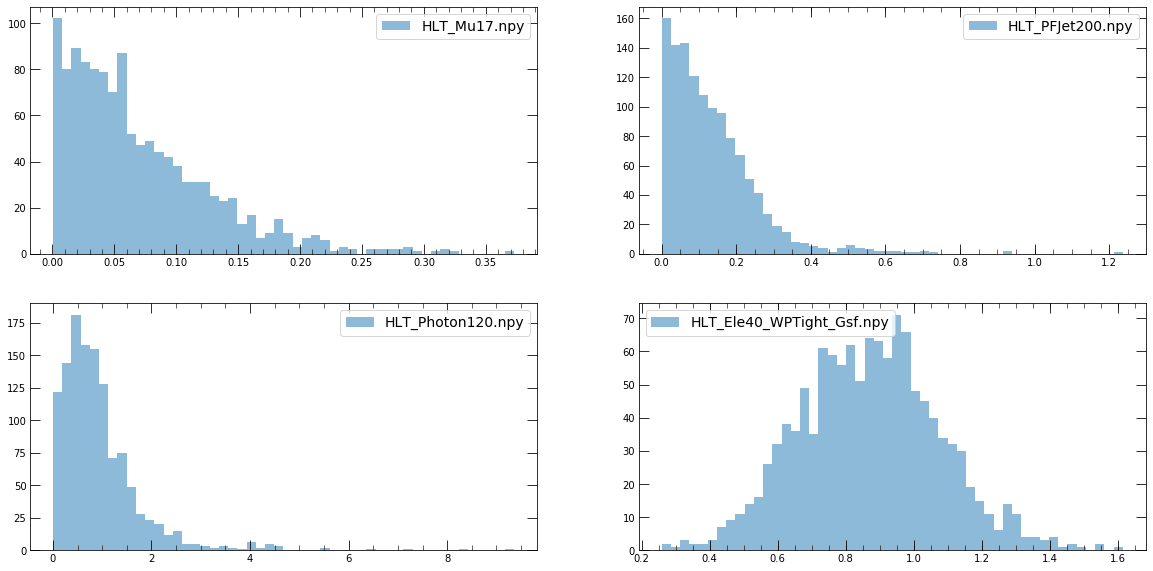

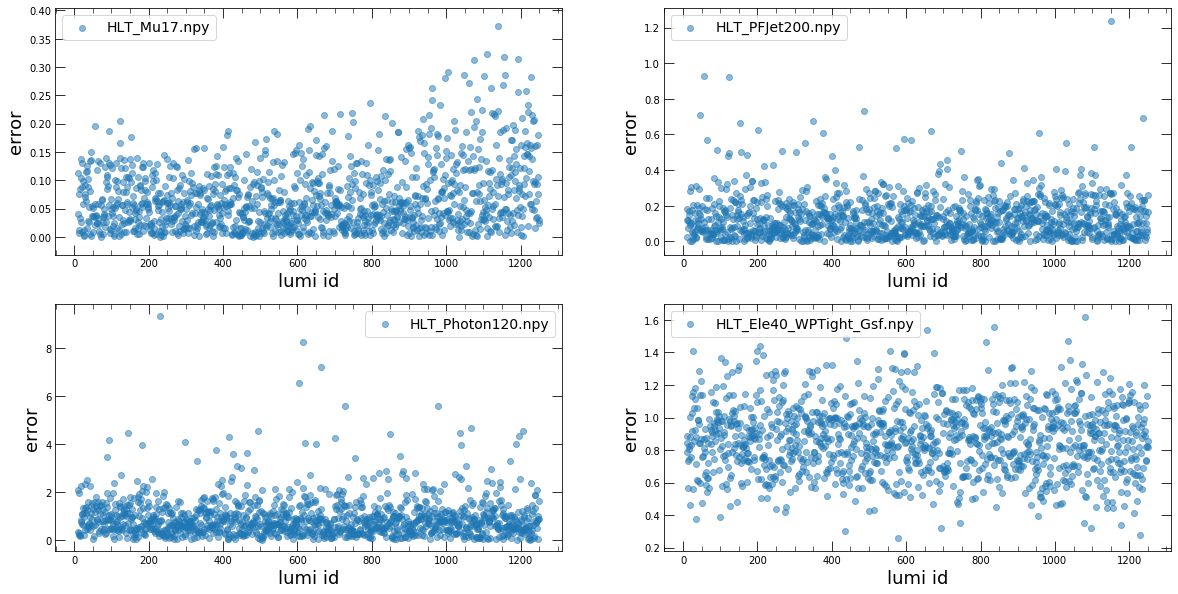

In [20]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

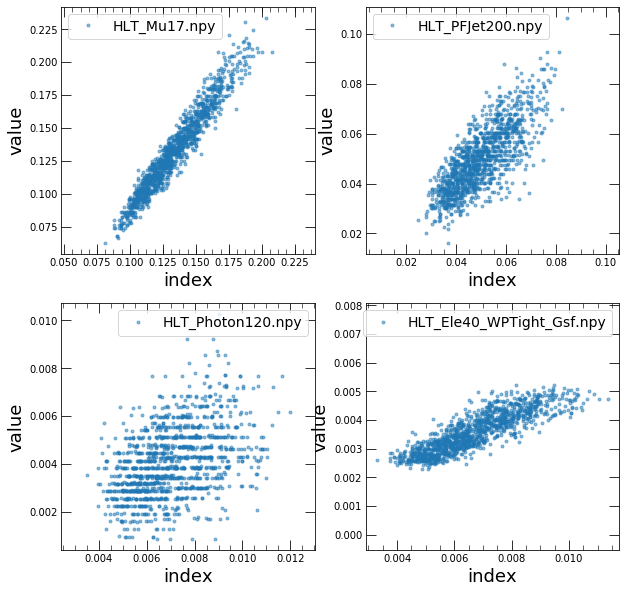

In [21]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [22]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [23]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [24]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [25]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [26]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


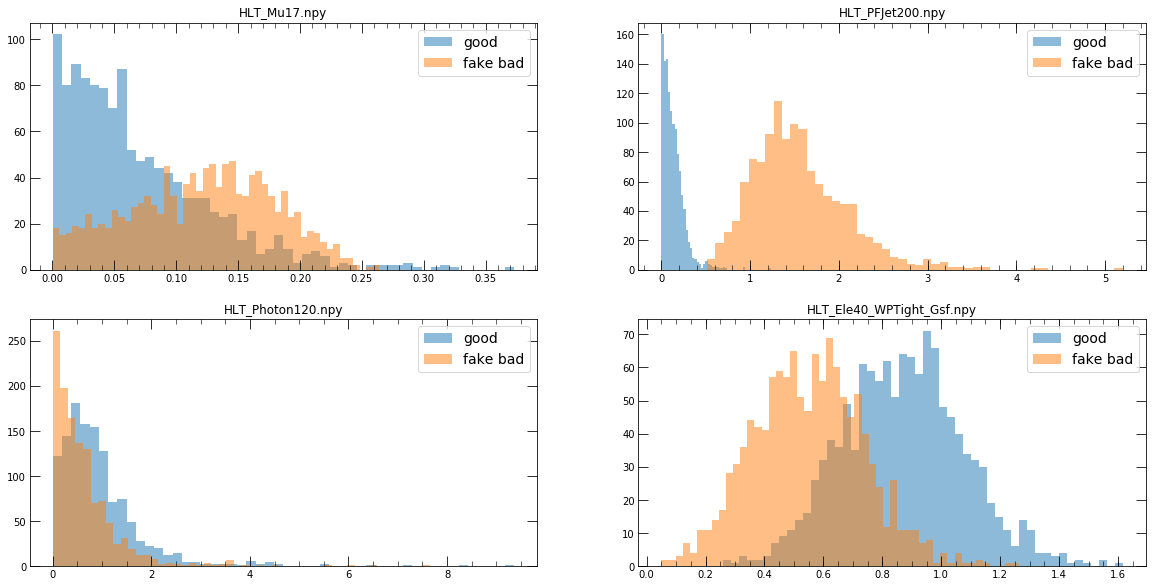

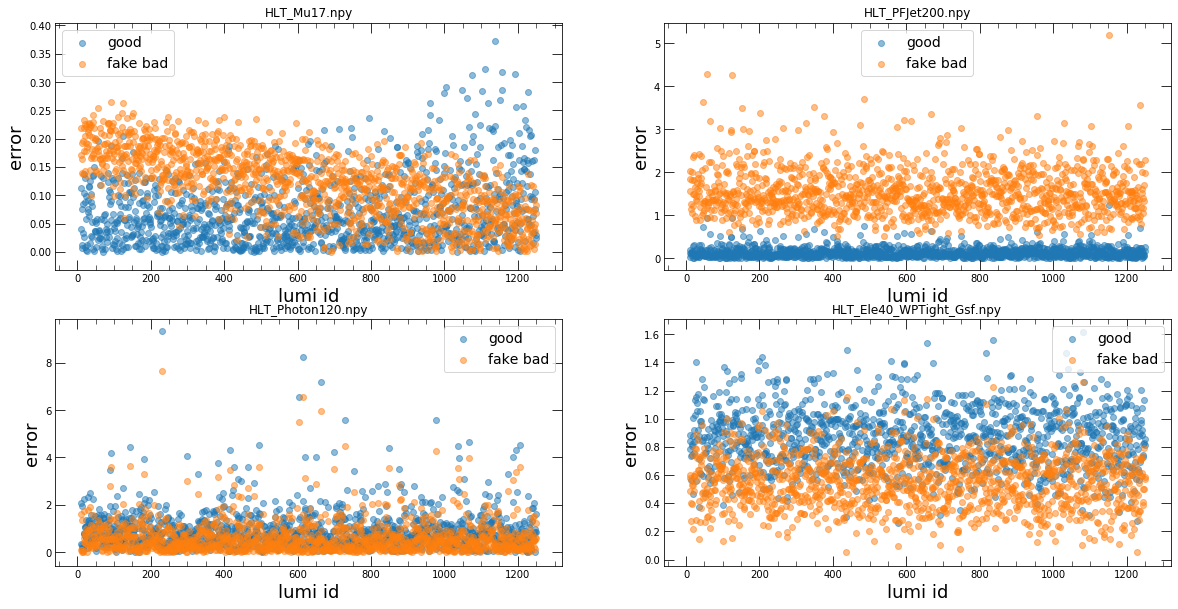

In [27]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

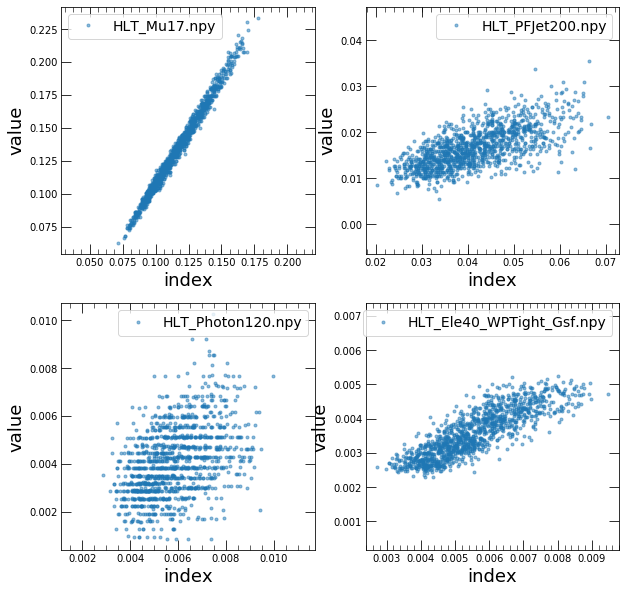

In [28]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [29]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [30]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [31]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [32]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [33]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


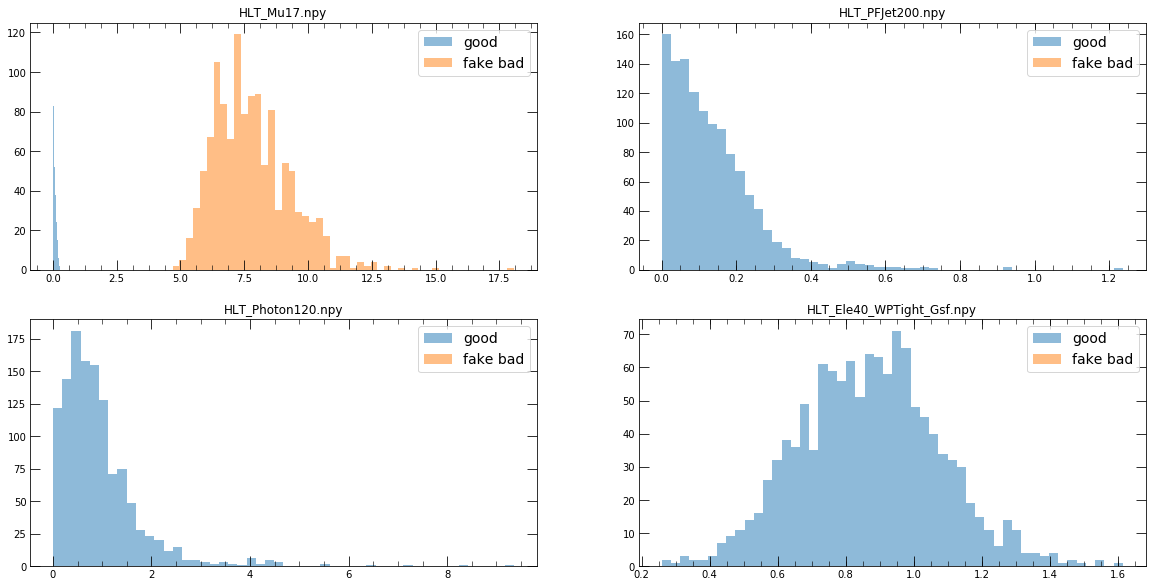

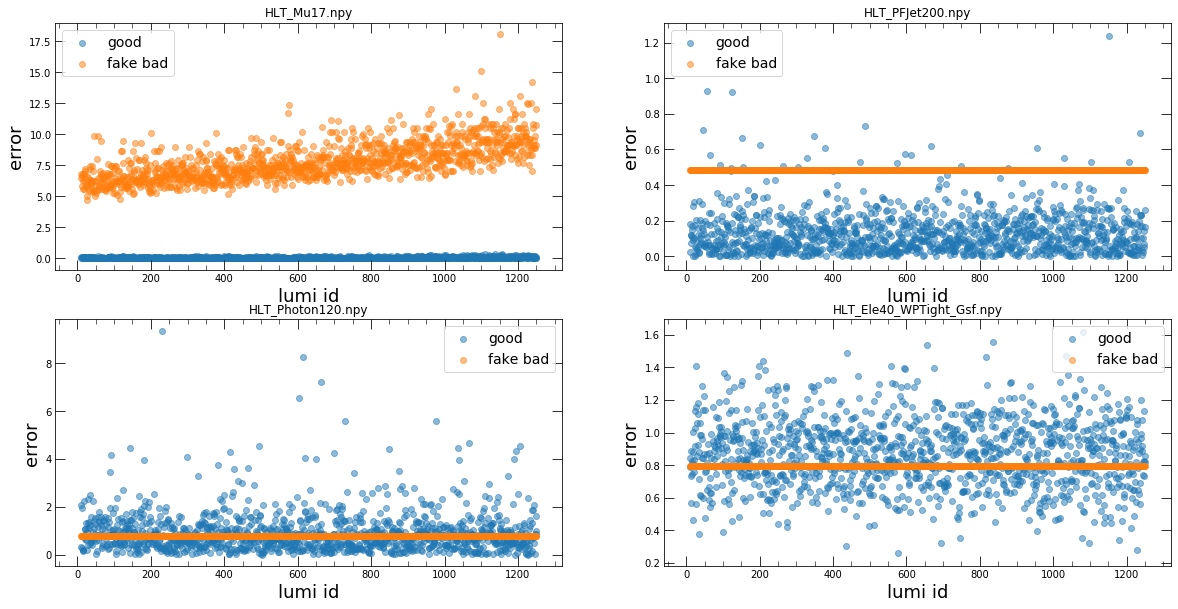

In [34]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

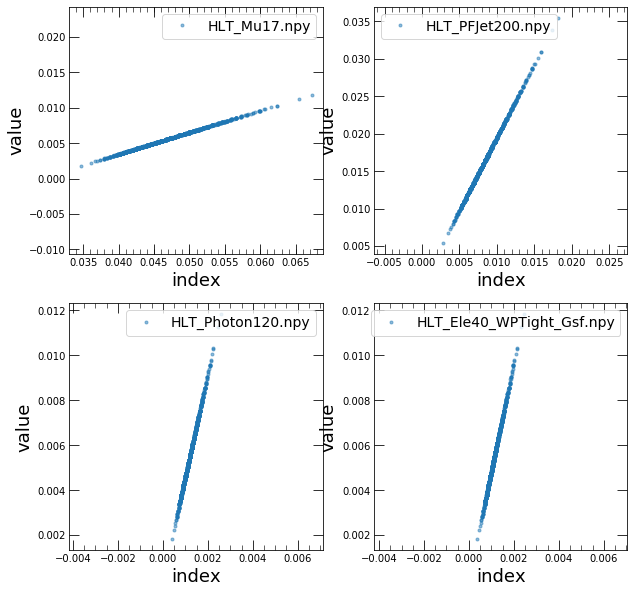

In [35]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [36]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [37]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [38]:
bad_runs = [301480]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [39]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [40]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


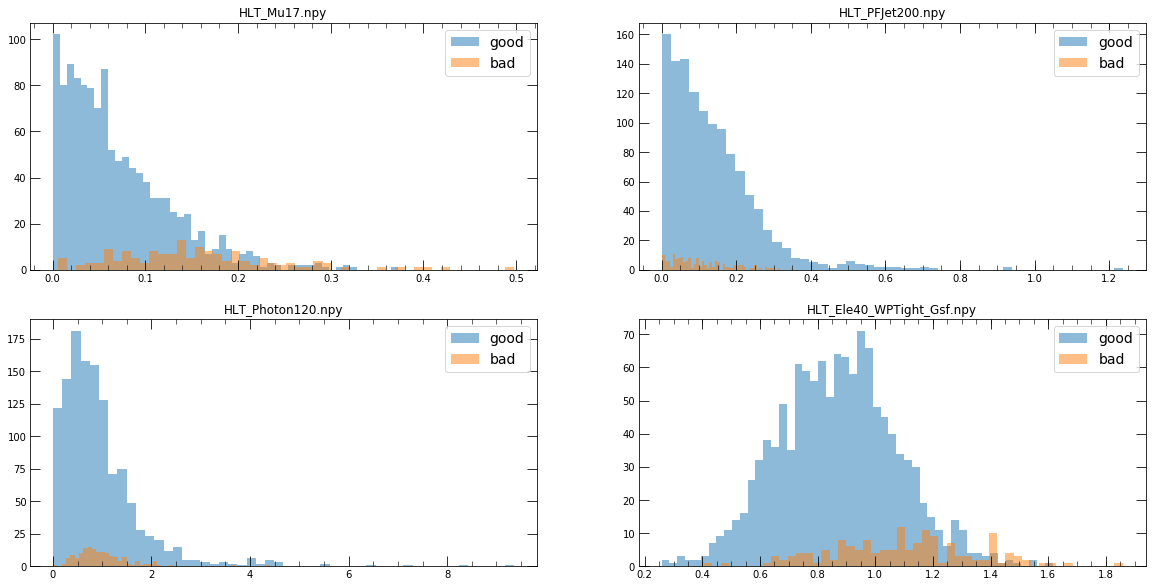

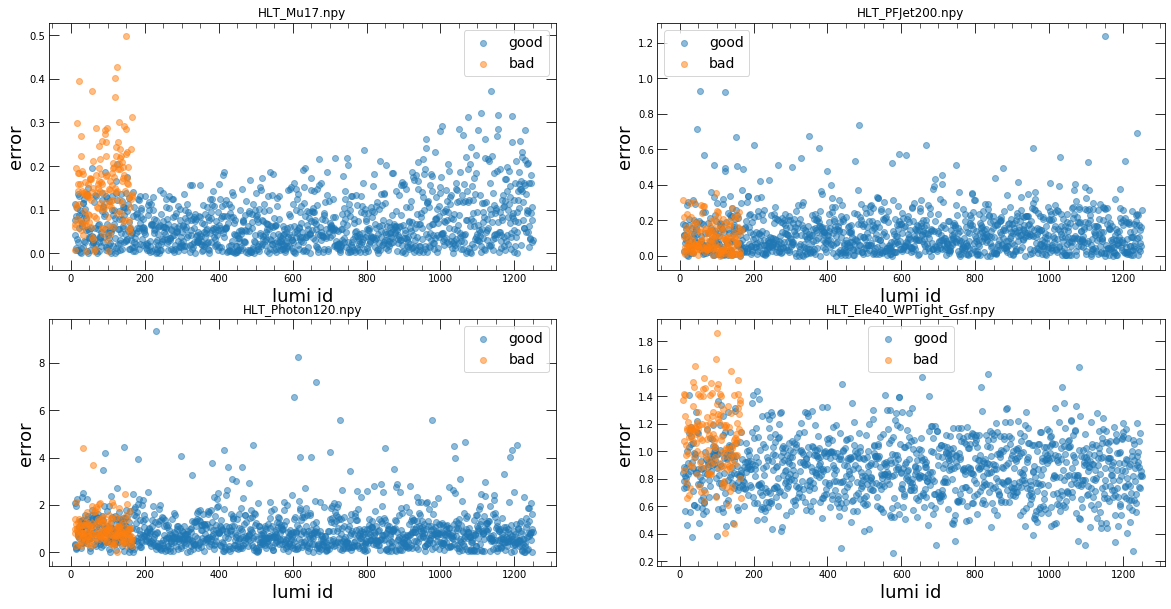

In [41]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

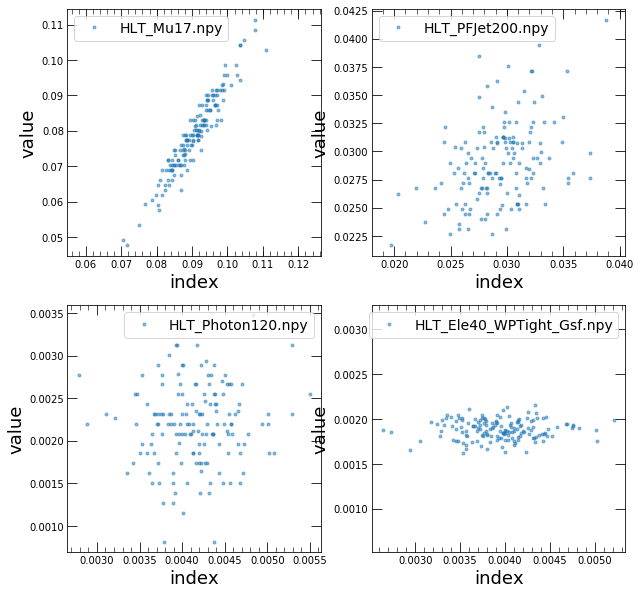

In [42]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [43]:
bad_runs = [305588]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [44]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [45]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


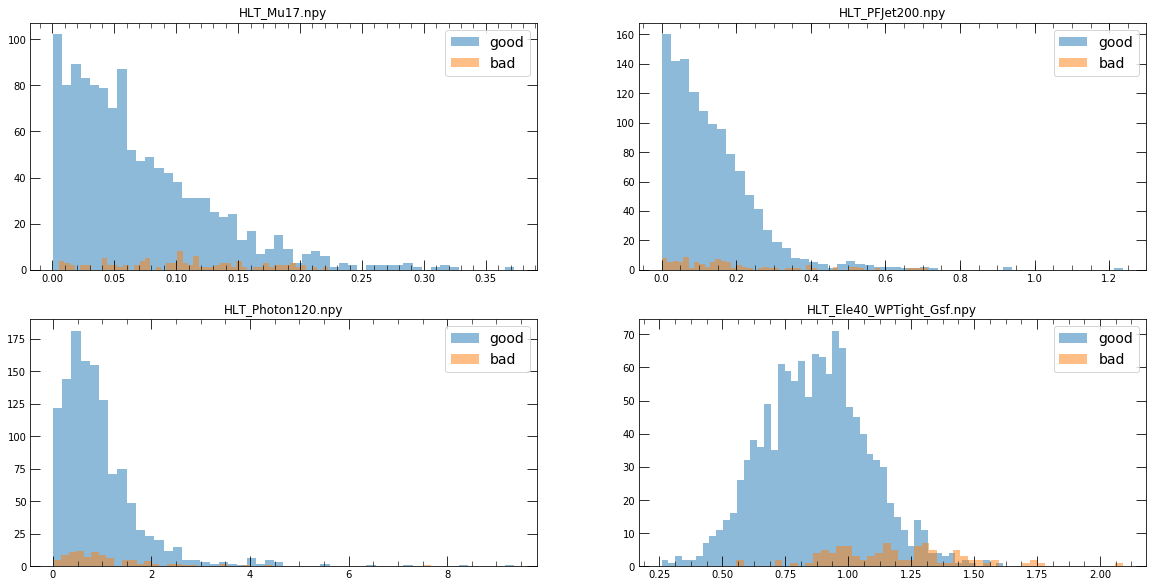

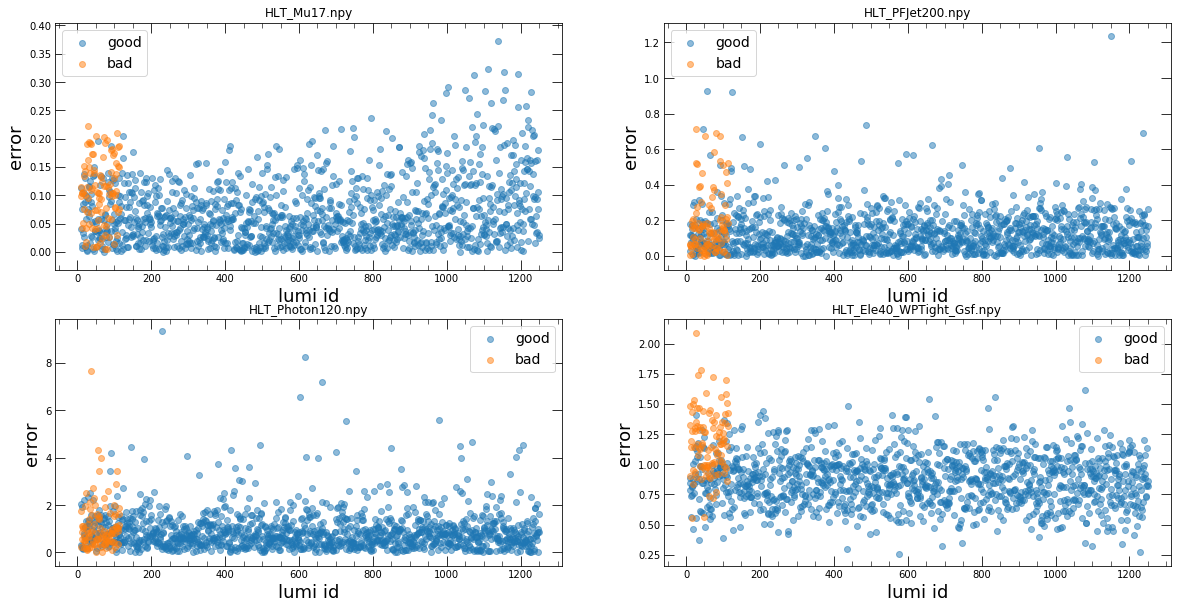

In [46]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

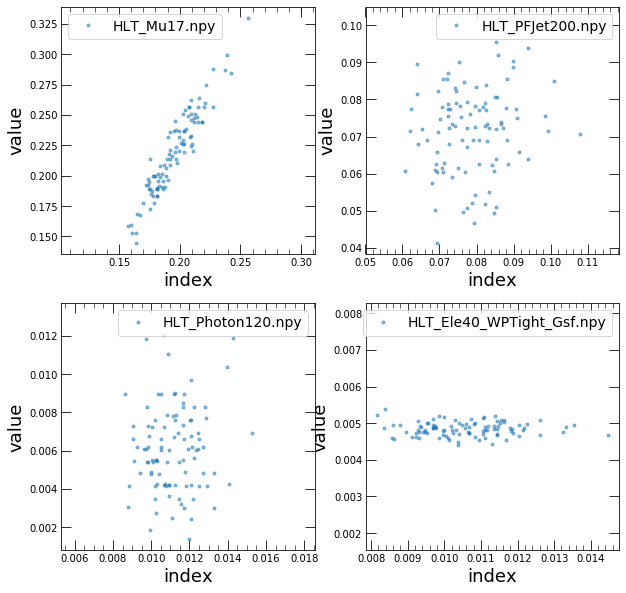

In [47]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()